In [1]:
!pip install contractions
!pip install WordCloud
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# conda install nomkl

# Initial Setup

In [3]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
import contractions
from contractions import contractions_dict

from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [4]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

In [7]:
filename = '/content/drive/MyDrive/NLP/news_summary_more.csv'
df = pd.read_csv(filename, encoding='latin')
df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [8]:
df_columns = df.columns.tolist()
df_columns.remove('headlines')
df_columns.remove('text')
df.drop(df_columns, axis='columns', inplace=True)

Since the RAM support is only for 12GB, we need to shorten the amount of data that we plan to use.

Hence we will be only using the first 35,000 records

In [9]:
df= df.head(20000)
df.columns = ['summary', 'reviewText']
df.isnull().sum()
df = df.dropna()
df.isnull().sum()

summary       0
reviewText    0
dtype: int64

In [10]:
df.head()

,summary,reviewText
0,Edtech startup Springboard raises $9.5 million...,US-based edtech startup Springboard has raised...
1,Men should learn to do household work: Sushma ...,External Affairs Minister Sushma Swaraj on Thu...
2,Why do bubbles rise in a zig-zag manner?,Air bubbles rise in water due to their buoyanc...
3,"Nick is fine with Mumbai now, it's his other h...","Actress Priyanka Chopra, while talking about h..."
4,"Woman strangles, buries 14-month-old son with ...",A 20-year-old woman in Maharashtra's Bhiwandi ...


In [ ]:
We can be sure our data has no null values, so it is ready to be preprocessed now.

# Data Preprocessing

In [1]:
## We will be removing contractions by expanding them to better understand context

## Then we remove punctuations, and remove numbers and special characters, as they don't mean much for us

## Lower-casing as there is no need for understanding capitalizations here

## and finally we remove stop words

In [11]:
def preprocess(text,remove_stopwords=True):
    
    lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
    stopwords = set(nltk.corpus.stopwords.words('english'))



    ## Using Contractions.fix to expand the contractinos that are present in the text
    contraction_text= contractions.fix(text)

    ## Handling the Punctuation 
    punctuated_s= re.sub('\'s', '', contraction_text )
    punctuated_appostrophe= re.sub('\'', '', punctuated_s ) 
    punctuated_text = re.sub(r"[^a-z0-9]+", ' ', punctuated_appostrophe)
    non_numbers= re.sub('[0-9]+', '', punctuated_text)

    ## Unicode handling by removing unicode characters (e.g emojis)
    string_encode = non_numbers.encode('ascii', 'ignore')
    string_decode = string_encode.decode()

    ## Making the raw-text to lower-case
    lower_text = string_decode.lower()
     
    
    ## Removing stop-words 
    if remove_stopwords== True:
      non_stopwords_text = '' 

      for word in string_decode.split():
          if word not in stopwords:
              non_stopwords_text+=word + " "

      return non_stopwords_text
      
    else:
      return string_decode

## We don't need the preprocess function to run on all the columns of the dataframe
## So we will just be applying this on the Review_Text column

##List of cleaned reviews
cleaned_reviews=[]
for review in df.reviewText:
    cleaned_reviews.append(preprocess(review))

##List of cleaned review summaries
cleaned_review_summaries=[]

for summary in df.summary:
    cleaned_review_summaries.append(preprocess(summary,remove_stopwords=False))


## Make this return tokens so just do non_stopwords_text.tokenize()


In [12]:
##List of cleaned reviews
cleaned_reviews=[]
for review in df.reviewText:
    cleaned_reviews.append(preprocess(review))

##List of cleaned review summaries
cleaned_review_summaries=[]

for summary in df.summary:
    cleaned_review_summaries.append(preprocess(summary,remove_stopwords=False))

In [13]:
df['reviewText']=cleaned_reviews
df['summary']=cleaned_review_summaries

In [14]:
df.summary = df.summary.apply(lambda x: f'_START_ {x} _END_')

In [15]:
start_token = 'sostok'
end_token = 'eostok'
df.summary = df.summary.apply(lambda x: f'{start_token} {x} {end_token}')

In [16]:
df.sample(5)


,summary,reviewText
81213,sostok _START_ ndia will develop km stretch ...,ighways ansukh andaviya hursday said ndia deve...
10137,sostok _START_ ohit harma plays gully cricket...,ndian cricketer ohit harma shared video wherei...
38910,sostok _START_ entral varsity in ihar to adop...,ahatma andhi entral niversity adopt five villa...
95271,sostok _START_ ak has links to terrorist grou...,hairman oint hiefs taff eneral oseph unford ue...
33805,sostok _START_ hat all do ndian ailways passe...,ailway rotection orce recovered stolen items l...


# Feature Engineering

We will visualise the length of summaries to have a better understanding of how to do our sequence padding

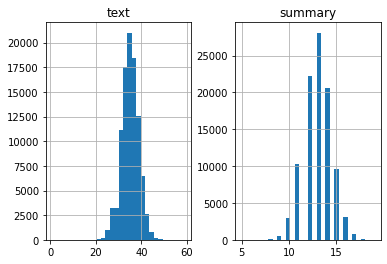

In [17]:
text_count = []
summary_count = []

# populate the lists with sentence lengths
for review in df['reviewText']:
      text_count.append(len(review.split()))

for summary in df['summary']:
      summary_count.append(len(summary.split()))


length_df = pd.DataFrame({'text':text_count, 'summary':summary_count})
length_df.hist(bins = 30)
plt.show()

In [18]:
# This is to find the maximum length of length of the sumamry and review text we have
review_len = []
summary_len = []

for review in df['reviewText']:
  review_len.append(len(review.split()))

for summary in df['summary']:
  summary_len.append(len(summary.split()))

review_max = max(review_len)
summary_max = max(summary_len)

In [19]:
# select the summary and text between their defined max lens respectively

cleaned_text = np.array(df.reviewText)
cleaned_summary = np.array(df.summary)

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_text[i].split()) <= review_max and len(
        cleaned_summary[i].split()
    ) <= summary_max:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({'reviewText': short_text, 'summary': short_summary})

In [21]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df.reviewText),
    np.array(df.summary),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

In [22]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

Next step is to convert these into integer sequences, and then finally into padded sequences, in order to ensure the vectors are of equal lengths for learning

<p>This returns the feature matrix, and process also called vectorization</p>

In [23]:
#convert text sequences into integer sequences
x_text2seq_train = x_tokenizer.texts_to_sequences(x_train)
x_text2seq_val = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_padseq_train = pad_sequences(x_text2seq_train, maxlen=review_max, padding='post')
x_padseq_test = pad_sequences(x_text2seq_val, maxlen=review_max, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

print(x_vocab_size)

72992


In [24]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))
print(y_tokens_data)

{'percent': 66.73, 'total_coverage': 3.73, 'count': 22560, 'total_count': 33810}


In [25]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [26]:
#convert text sequences into integer sequences
y_text2seq_train = y_tokenizer.texts_to_sequences(y_train)
y_text2seq_val = y_tokenizer.texts_to_sequences(y_val)

#creating the feature Matrices for Reviews_Train and Reviews_Test
y_train_padded = pad_sequences(y_text2seq_train, maxlen=summary_max, padding='post')
y_val_padded = pad_sequences(y_text2seq_val, maxlen=summary_max, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

In [27]:
print(y_vocab_size)

33811


In [28]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_padseq_train = np.delete(x_padseq_train, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_padseq_train = np.delete(x_padseq_train, remove_val_indexes, axis=0)

In [29]:
latent_dim = 240
embedding_dim = 300
num_epochs = 5

# Creating Word Embeddings

In [2]:
## We use a pretrained word-embeddigns model, and inspecific, this one as it is much better at handling the OOV's 
## compared to otehr models like genshim

In [32]:
# download glove and unzip it in Notebook.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-11-10 17:57:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-10 17:57:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-10 17:57:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [33]:
## Code taken sourced https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/

def get_embedding_matrix(tokenizer,vocab_size, embedding_dim):
    path = 'glove.6B.300d.txt'

    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,embedding_dim))
  
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
  
    return embedding_matrix_vocab

x_embedding_matrix = get_embedding_matrix(x_tokenizer, x_vocab_size, embedding_dim)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, y_vocab_size, embedding_dim)

In [34]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(72992, 300)
(33811, 300)


Now we are ready to create our models, and then train them, we begin with the simple unidirectinal model fro LSTM,and then we will implement the Hybrid model, where encoder is bi-directional and decoder is unidirectional

# Model Creation: Simple LSTM

In [35]:
def build_seq2seq_model_with_just_lstm(embedding_dim, latent_dim, max_text_len, x_vocab_size, y_vocab_size,x_embedding_matrix, y_embedding_matrix):
 
    with tpu_strategy.scope():    

                                  ## Encoder
        encoder_input = Input(shape=(review_max, ))

        # encoder embedding layer
        encoder_embedding = layers.Embedding(
            input_dim= len(x_vocab_size),
            output_dim= embedding_dim,
            trainable=True)

        encoder_embed = encoder_embedding(encoder_input)

        # encoder LSTM layer
        encoderLstm = layers.LSTM( name= 'encoderLstm',
                                   units=lstm_units, 
                                   dropout=0.4,
                                   return_sequences=True, 
                                   return_state=True)

        x_out, state_h, state_c = encoderLstm(encoder_embed)
        encoder_output, *encoder_final_states = encoder_lstm(
            encoder_embedding, initial_state=encoder_final_states
        )
                                ## Decoder

        decoder_input = layers.Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = layers.Embedding(
                                       input_dim=y_vocab_size, 
                                       output_dim=embedding_dim, 
                                       trainable=True)

        decoder_embedding = decoder_embedding(decoder_input)

        ### decoder LSTM Layer 
        decoder_lstm = layers.LSTM( name= 'decoder_lstm',
                                   units=lstm_units, 
                                   dropout=0.4,
                                   return_sequences=True, 
                                   return_state=True)
        decoder_output, *decoder_final_states = decoder_lstm(decoder_embedding, initial_state=encoder_final_states )

        ### dense layers


        layer_dense = layers.TimeDistributed(
                                              layer=layers.Dense(
                                                                  units=y_vocab_size,
                                                                  activation='softmax'))
        decoder_output = decoder_dense(decoder_output)


        ##                                Model
        model = models.Model(inputs=[encoder_input, decoder_input],
                             outputs=y_out)
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        model.summary()
        
        return {
            'model': model,
            'encoder_decoder_input': {
                'encoder_input': encoder_input,
                'decoder_input': decoder_input
            },
            'encoder_decoder_output': {
                'encoder_output': encoder_output,
                'decoder_output': decoder_output
            },
            'encoder_decoder_states': {
                'encoder_final_state': encoder_final_states,
                'decoder_final_state': decoder_final_states
            },
            'decoder_layer': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }







In [36]:
seq2seq = build_seq2seq_model_with_just_lstm(embedding_dim, latent_dim, review_max, x_vocab_size, y_vocab_size,x_embedding_matrix, y_embedding_matrix)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 59)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 59, 300)      21897600    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 59, 240),    519360      ['embedding[0][0]']              
                                 (None, 240),                                                 

In [37]:
## For more structured processing, code sourced from: 

model = seq2seq['model']

encoder_input = seq2seq['encoder_decoder_input']['encoder_input']
decoder_input = seq2seq['encoder_decoder_input']['decoder_input']

encoder_output = seq2seq['encoder_decoder_output']['encoder_output']
decoder_output = seq2seq['encoder_decoder_output']['decoder_output']

encoder_final_states = seq2seq['encoder_decoder_states']['encoder_final_state']
decoder_final_states = seq2seq['encoder_decoder_states']['decoder_final_state']

decoder_embedding_layer = seq2seq['decoder_layer']['decoder']['embedding']
last_decoder_lstm = seq2seq['decoder_layer']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['decoder_layer']['decoder']['dense']



In [38]:
num_epochs = 50
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]


In [39]:
history = model.fit(
    [x_padseq_train, y_train_padded[:, :-1]],
    
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    
    ## TPU processing for ML Fitting
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
87/87 [==============================] - 62s 410ms/step - loss: 4.9368 - accuracy: 0.4155 - val_loss: 4.0377 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 12s 138ms/step - loss: 3.9973 - accuracy: 0.5156 - val_loss: 3.8225 - val_accuracy: 0.5254 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 14s 158ms/step - loss: 3.8462 - accuracy: 0.5219 - val_loss: 3.7174 - val_accuracy: 0.5301 - lr: 0.0010
Epoch 4/50
87/87 [==============================] - 12s 141ms/step - loss: 3.7359 - accuracy: 0.5270 - val_loss: 3.6213 - val_accuracy: 0.5354 - lr: 0.0010
Epoch 5/50
87/87 [==============================] - 13s 144ms/step - loss: 3.6298 - accuracy: 0.5315 - val_loss: 3.5273 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 6/50
87/87 [==============================] - 12s 141ms/step - loss: 3.5078 - accuracy: 0.5365 - val_loss: 3.4279 - val_accuracy: 0.5428 - lr: 0.0010
Epoch 7/50
87/87 [==============================] - 12s 140ms/st

In [73]:
## To save the model and not requiring to train it again once session closes

import pickle
pickle.dump(history, open('modelLSTM.pkl', 'wb'))

In [ ]:
# ## Loading the saved model

# import pickle
# with open('modelLSTM.pkl' , 'rb') as f:
#     history = pickle.load(f)

# Model Inference: Simple LSTM

In [40]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
target_index = y_tokenizer.index_word
word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index


In [41]:
## Code taken from https://stackoverflow.com/questions/60697843/tensorflow-keras-bidirectional-lstm-for-text-summarization

def build_seq2seq_model_with_just_lstm_inference(max_text_len, latent_dim, encoder_input, encoder_output, encoder_final_states, decoder_input, decoder_output,decoder_embedding_layer, decoder_dense, last_decoder_lstm):
    lstm_hidden_layers=latent_dim
    review_max=max_text_len
    encoder_state_1 = encoder_input
    encoder_state_2 = encoder_output
    
    encoder_model = Model(inputs=encoder_state_1, outputs=[encoder_state_2] + encoder_final_states)
    decoder_h = Input(shape=(lstm_hidden_layers, ))
    decoder_c = Input(shape=(lstm_hidden_layers, ))
    decoder_hidden_state = Input(shape=(review_max, lstm_hidden_layers))
    
    decoder_state_1=decoder_input
    decoder_state_2= decoder_output
    
    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_state_1)

## In order to get the state from the previous state, we set initial state of decoder as initial state of decoder
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_h, decoder_c])
    
    decoder_state_2 = decoder_dense(decoder_state_2)

    decoder_model = Model(
        [decoder_state_1] + [decoder_hidden_state, decoder_h, decoder_c], 
        [decoder_state_2] + decoder_states
    )

    return (encoder_model, decoder_model)



In [42]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference( review_max, latent_dim, encoder_input, 
                                                                            encoder_output,encoder_final_states, decoder_input, decoder_output,decoder_embedding_layer, 
                                                                            decoder_dense, last_decoder_lstm)

encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 59)]              0         
                                                                 
 embedding (Embedding)       (None, 59, 300)           21897600  
                                                                 
 lstm (LSTM)                 [(None, 59, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 59, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 22,878,720
Trainable params: 981,120
Non-trai

In [43]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    10143300    ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 240)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 240)]        0           []                               
                                                                                            

In [44]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [45]:
def decode_sequence_seq2seq_model_with_just_lstm(input_sequence, encoder_model, decoder_model):
    # Encode the input as state vectors.
    enoceder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence)

    targetSequence = np.zeros((1, 1))
    targetSequence[0, 0] = target_word_index[start_token]

    stop = False
    decoded = ''

    while not stop:
        output_words, h, c = decoder_model.predict(
            [targetSequence] + [enoceder_output, encoder_h, encoder_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_words[0, -1, :])
        sampled_token = target_index[sampled_token_index]

        if sampled_token != end_token:
            decoded += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded.split()) >= (summary_max - 1)):
            stop = True

        # Update the target sequence (of length 1).
        targetSequence = np.zeros((1, 1))
        targetSequence[0, 0] = sampled_token_index

        # Update internal states
        encoder_h, encoder_c = h, c

    return decoded

In [46]:
def sequence2summary(inputSequence):
    summary = ''
    for i in inputSequence:
        if ((i != 0 and i != target_word_index[start_token]) and(i != target_word_index[end_token])):
            summary = summary + target_index[i] + ' '
    return summary

In [47]:
def sequence2text(inputSequence):
    summary = ''
    for i in inputSequence:
        if i != 0:
            summary = summary + reverse_source_word_index[i] + ' '
    return summary

In [48]:
def textPrediction(sample, decode_sequence, encoder_model, decoder_model):
    original_text = sample
    sample = preprocess(sample)  # generator
    tokens = original_text.split()
    
    if len(tokens) <= review_max:
        sample = preprocess(text)
        
        ## Adding the Start and end tokens in the sample text
        sample = f'_START_ {sample} _END_'
        
        ## To account for certiain errors in indertifying the _START_ and _END_
        sample = f'{start_token} {text} {end_token}'

        sequence = x_tokenizer.texts_to_sequences([' '.join(tokens)])
        paddedSequence = pad_sequences(sequence, maxlen=review_max, padding='post')
        predictedSummary = decode_sequence(paddedSequence.reshape(1, review_max), encoder_model, decoder_model)
        
        return predictedSummary
    
    else:
        predictedSummary = ''
        while len(tokens) % review_max == 0:
            tokens.append('')

        lst_i = review_max
        for i in range(0, len(tokens), review_max):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(_text.split())  
            _text = preprocess (_text)
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            
            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=review_max, padding='post')
            _pred = decode_sequence(_padded.reshape(1, review_max), encoder_model, decoder_model)
            predictedSummary += ' ' + ' '.join(_pred.split()[1:-2])
            predictedSummary = ' '.join(predictedSummary.split())

        return predictedSummary

In [49]:
print(summary_max)

19


# Model Evaluation: Simple LSTM

In [50]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", sequence2text(x_padseq_train[i]))
    print("Original summary: ", sequence2summary(y_train_padded[i]))
    print("Predicted summary: ", decode_sequence_seq2seq_model_with_just_lstm(x_padseq_train[i].reshape(1, review_max), encoder_model,decoder_model))

# 1 News:  ata roup abur ndia among suitors selected second round bidding raft einz ndia sale n addition omplan product ndian businesses reportedly sold include lucon energy drink ycil talcum powder ampriti ghee raft einz seeking billion assets reports added 
Original summary:  start ata abur among bidders for raft einz ndia sale eport end 
1/1 [==============================] - 0s 66ms/step
Predicted summary:   start ata roup to sell majority stake in ndia in ndia end

# 2 News:  x world number one tennis player lie astase used nicknamed asty arrested twice within six hours omania riday year old first arrested suspicion driving car drunk refusing take reathalyzer test later released e later arrested going red light scooter 
Original summary:  start x world no tennis player asty arrested twice in day end 
1/1 [==============================] - 0s 75ms/step
Predicted summary:   start year old world no urray arrested for drunk driving end

# 3 News:  esla lon usk disclosed automaker fire

In [52]:
# ## writing text down in two files which will then be compared to calculate rouge score for evaluation
for i in range(0,y_train.shape[0]):

    training_file = open("train.txt", "a")
    training_file.write(sequence2text(x_padseq_train[i])+'\n')

    prediction_file = open("predictionLSTM.txt", "a")
    prediction_file.write(sequence2text(decode_sequence_seq2seq_model_with_just_lstm( x_padseq_train[i].reshape(1, review_max), encoder_model,decoder_model)+'\n'))


In [53]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", sequence2text(x_val_padded[i]))
    print("Original summary: ", sequence2summary(y_val_padded[i]))
    print("Predicted summary: ",decode_sequence_seq2seq_model_with_just_lstm(x_val_padded[i].reshape(1, review_max), encoder_model,decoder_model))

# 1 News:  group lawyers representing teachers students three schools alifornia sued state dragging nation literacy education lawsuit stated lowest performing school alifornia state failed adopt adequate plan tackle issue lawyer said 
Original summary:  start alifornia sued for dragging down in literacy end 
1/1 [==============================] - 0s 66ms/step
Predicted summary:   start erala schools to pay for students who slammed for teaching end

# 2 News:  urugram based logistics startup raised million eries funding round valuation around million according reports xisting investors artners arburg incus participated startup funding round reports added ounded manages long haul logistics services caters sectors pharmaceuticals e commerce 
Original summary:  start tartup raises mn at mn valuation eport end 
1/1 [==============================] - 0s 78ms/step
Predicted summary:   start intech startup raises mn in eries funding in eries end

# 3 News:  elhi headquartered e learning platfo

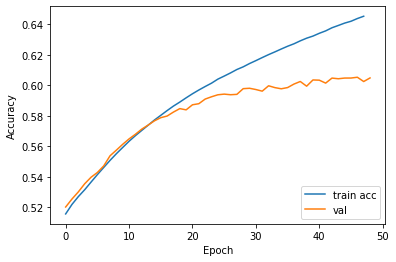

In [54]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy_Values')
plt.legend(loc='lower right')

# Model Creation: Hybrid LSTM

In [55]:
def build_hybrid_seq2seq_model(embedding_dim, latent_dim, max_text_len, x_vocab_size, y_vocab_size,x_embedding_matrix, y_embedding_matrix):   
      with tpu_strategy.scope():       
                        
                        ## Encoder
            
        encoder_input = Input(shape=(review_max, ))

        # encoder embedding layer
        encoder_embedding = layers.Embedding(
            input_dim= len(x_vocab_size),
            output_dim= embedding_dim,
            trainable=False)(encoder_input)
           
            
         ### bi-lstm 1
        encoder_biLSTM = layers.Bidirectional(
                    layers.LSTM(
                        units= lstm_units,
                        dropout=0.4,
                        recurrent_dropout=0.4,
                        return_sequences=True,
                        return_state=True,
                        name="encoder_lstm_1" ) )

        encoder_output_1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_biLSTM(encoder_embedding)
        encoder_bi_lstm1_output = [encoder_output_1, forward_h1, forward_c1, backward_h1, backward_c1]

        
        ### bi-lstm 2
        encoder_biLSTM = layers.Bidirectional(
                      layers.LSTM(
                          units= lstm_units,
                          dropout=0.2,
                          recurrent_dropout=0.2,
                          return_sequences=True,
                          return_state=True,
                          name="encoder_lstm_2" ) )

        encoder_output_2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_biLSTM(encoder_output_1)
        encoder_bi_lstm2_output = [encoder_output_2, forward_h2, forward_c2, backward_h2, backward_c2]



        ### bi-lstm 3( where we collect the final states of the 3 encoder layers)
        encoder_biLSTM = layers.Bidirectional(
                      layers.LSTM(
                          units= lstm_units,
                          dropout=0.2,
                          recurrent_dropout=0.2,
                          return_sequences=True,
                          return_state=True,
                          name="encoder_lstm_3" ) )

         encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

                    
                        ## Decoder
                    
        ## We will now be doing the decoder layers and will use the ending state of the encoder as the initial state of the decoder
        decoder_input = layers.Input(shape=(None,))


        ### Decoder embedding
        decoder_embedding_layer = layers.Embedding(
                                       input_dim=y_vocab_size, 
                                       output_dim=embedding_dim, 
                                       trainable=True)
        
        decoder_embedding = decoder_embedding_layer(decoder_input)


        decoderLSTM= layers.LSTM(
                              units=lstm_units,
                              return_sequences=True,
                              return_state=True,
                              dropout=0.4,
                              recurrent_dropout=0.2)

        decoder_output, *decoder_final_states = decoder_lstm(decoder_embedding, initial_state=encoder_final_states[:2]) 



                        ## Dense Layer
        decoder_dense = layers.TimeDistributed(
                layer= layers.Dense(
                units=len(y_vocab_size),
                activation='softmax')
                                              )
        decoder_output = decoder_dense(decoder_output)

        ## Running the model
        model = models.Model(inputs=[encoder_input, decoder_input], 
                              outputs= decoder_output,
                              name='seq2seq')

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        model.summary()   
        
        return {
            'model': model,
            'encoder_decoder_input': {
                'encoder_input': encoder_input,
                'decoder_input': decoder_input
            },
            'encoder_decoder_output': {
                'encoder_output': encoder_output,
                'decoder_output': decoder_output
            },
            'encoder_decoder_states': {
                'encoder_final_state': encoder_final_states,
                'decoder_final_state': decoder_final_states
            },
            'decoder_layer': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }




    

In [56]:
seq2seqLSTM = build_hybrid_seq2seq_model(embedding_dim, latent_dim, review_max, x_vocab_size, y_vocab_size,x_embedding_matrix, y_embedding_matrix)

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 59)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 59, 300)      21897600    ['input_6[0][0]']                
                                                                                                  
 encoder_bidirectional_lstm_1 (  [(None, 59, 480),   1038720     ['encoder_embedding[0][0]']      
 Bidirectional)                  (None, 240),                                                     
                                 (None, 240),                                                     
                                 (None, 240),                 

In [57]:
## For more structured processing
model = seq2seq['model']

encoder_input = seq2seq['encoder_decoder_input']['encoder_input']
decoder_input = seq2seq['encoder_decoder_input']['decoder_input']

encoder_output = seq2seq['encoder_decoder_output']['encoder_output']
decoder_output = seq2seq['encoder_decoder_output']['decoder_output']

encoder_final_states = seq2seq['encoder_decoder_states']['encoder_final_state']
decoder_final_states = seq2seq['encoder_decoder_states']['decoder_final_state']

decoder_embedding_layer = seq2seq['decoder_layer']['decoder']['embedding']
last_decoder_lstm = seq2seq['decoder_layer']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['decoder_layer']['decoder']['dense']



In [58]:
num_epochs = 50
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]


In [59]:
history = model.fit(
    [x_padseq_train, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50


87/87 [==============================] - 88s 585ms/step - loss: 5.0326 - accuracy: 0.4011 - val_loss: 4.1360 - val_accuracy: 0.5118 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 23s 265ms/step - loss: 4.0549 - accuracy: 0.5115 - val_loss: 3.8890 - val_accuracy: 0.5226 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 23s 266ms/step - loss: 3.9221 - accuracy: 0.5184 - val_loss: 3.8032 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 4/50
87/87 [==============================] - 23s 268ms/step - loss: 3.8367 - accuracy: 0.5209 - val_loss: 3.7296 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 5/50
87/87 [==============================] - 23s 265ms/step - loss: 3.7420 - accuracy: 0.5240 - val_loss: 3.6383 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 6/50
87/87 [==============================] - 23s 265ms/step - loss: 3.6213 - accuracy: 0.5273 - val_loss: 3.5222 - val_accuracy: 0.5354 - lr: 0.0010
Epoch 7/50
87/87 [==============================] - 23s 266ms/step - loss: 

# Model Inference: Hybrid LSTM

In [60]:
def build_hybrid_seq2seq_model_inference(max_text_len, latent_dim, encoder_input, encoder_output, encoder_final_states, decoder_input, decoder_output, decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm):
    
    lstm_hidden_layers=latent_dim
    review_max=max_text_len
    encoder_state_1 = encoder_input
    encoder_state_2 = encoder_output
    
    # Encode the input sequence to get the feature vector
    encoder_model = Model( inputs=encoder_state_1, outputs=[encoder_state_2] + encoder_final_states )
    
    decoder_h = Input(shape=(lstm_hidden_layers, ))
    decoder_c = Input(shape=(lstm_hidden_layers, ))

    ## Since bi-driectional we get 2 times the  hidden layers
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))     
    decoder_initial_state = [decoder_h, decoder_c]
    
    decoder_state_1 = decoder_input
    decoder_state_2 = decoder_output

    decoder_embedding = decoder_embedding_layer(decoder_state_1)
    decoder_state_2, *decoder_states = last_decoder_bi_lstm(decoder_embedding, initial_state=decoder_initial_state)
    decoder_state_2 = decoder_dense(decoder_state_2)

    decoder_model = Model( [decoder_state_1] + [decoder_hidden_state_input] + decoder_initial_state,[decoder_state_1] + decoder_states
    )

    return (encoder_model, decoder_model)

In [61]:
def decode_sequence_hybrid_seq2seq_model(input_sequence, encoder_model, decoder_model):
    # Encode the input as state vectors.
    encoder_output, *state_values = encoder_model.predict(input_sequence)
    targetSequence = np.zeros((1, 1))

    targetSequence[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded = ''
    
    while not stop_condition:
        output_words, *decoder_states = decoder_model.predict(
            [targetSequence] + [encoder_output] + state_values[:2]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_words[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]
        
        if sampled_token != end_token:
            decoded += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded.split()) >= (review_max- 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        targetSequence = np.zeros((1, 1))
        targetSequence[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded



   

In [62]:
models_info = {
    'hybrid_lstm': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

In [63]:
inference_func = models_info['hybrid_lstm']['inference']
decode_sequence_func = models_info['hybrid_lstm']['decode_sequence']

encoder_model, decoder_model = inference_func(
    review_max, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [64]:
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 59)]              0         
                                                                 
 encoder_embedding (Embeddin  (None, 59, 300)          21897600  
 g)                                                              
                                                                 
 encoder_bidirectional_lstm_  [(None, 59, 480),        1038720   
 1 (Bidirectional)            (None, 240),                       
                              (None, 240),                       
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 encoder_bidirectional_lstm_  [(None, 59, 480),        1384320   
 2 (Bidirectional)            (None, 240),                 

In [65]:
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 decoder_embedding (Embedding)  (None, None, 300)    10143300    ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 240)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 240)]        0           []                               
                                                                                            

# Model Evaluation: Hybrid LSTM

In [4]:
# ## writing text down in two files which will then be compared to calculate rouge score for evaluation
for i in range(0,y_train.shape[0]):

    prediction_file = open("predictionLSTMHybrid.txt", "a")
    prediction_file.write(sequence2text(decode_sequence_hybrid_seq2seq_model( x_padseq_train[i].reshape(1, review_max), encoder_model,decoder_model)+'\n'))


In [66]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", sequence2text(x_padseq_train[i]))
    print("Original summary: ", sequence2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_padseq_train[i].reshape(1, review_max), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  ata roup abur ndia among suitors selected second round bidding raft einz ndia sale n addition omplan product ndian businesses reportedly sold include lucon energy drink ycil talcum powder ampriti ghee raft einz seeking billion assets reports added 
Original summary:  start ata abur among bidders for raft einz ndia sale eport end 
1/1 [==============================] - 0s 72ms/step
Predicted summary:   sostok radesh longer in an used of rump longer after will start to end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end

# 2 News:  x world number one tennis player lie astase used nicknamed asty arrested twice within six hours omania riday year old first arrested suspicion driving car drunk refusing take reathalyzer test later released e later arrested going red light scooter 
Original summary:  start x world no tennis player asty arrested twice in day

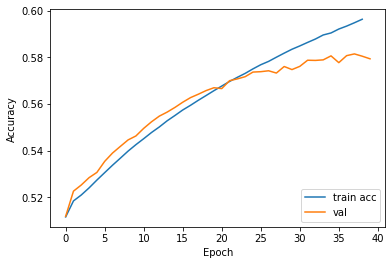

In [67]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Model Evaluation Rogue Scores

In [68]:
!pip install -U git+https://github.com/pltrdy/pyrouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pltrdy/pyrouge to /tmp/pip-req-build-f64mtig4
  Running command git clone -q https://github.com/pltrdy/pyrouge /tmp/pip-req-build-f64mtig4
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191927 sha256=6d7c03f12da600d3f771a4cbc41f45e23da50cc4423dd7923caa8d6f2fd95086
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ds600o_/wheels/e1/62/5a/26906774ed135498e54c3d7fba2320e2c6fb758b0f894a4bb3
Successfully built pyrouge


In [82]:
## We used the rogue metric from this python wrapper library


## commands ran in terminal
# git clone https://github.com/pltrdy/files2rouge.git     
# cd files2rouge
# python setup_rouge.py
# python setup.py install

In [80]:
files2rouge test.txt predictionLSTM.txt.txt 


Preparing documents...
Running ROUGE...
---------------------------------------------
1 ROUGE-1 Average_R: 0.43467 (95%-conf.int. 0.38721 - 0.47877)
1 ROUGE-1 Average_P: 0.391127 (95%-conf.int. 0.31114 - 0.47506)
1 ROUGE-1 Average_F: 0.37196 (95%-conf.int. 0.34704 - 0.41722)
---------------------------------------------
1 ROUGE-2 Average_R: 0.15215 (95%-conf.int. 0.08298 - 0.17600)
1 ROUGE-2 Average_P: 0.18458 (95%-conf.int. 0.14873 - 0.24023)
1 ROUGE-2 Average_F: 0.11489 (95%-conf.int. 0.08303 - 0.16741)
---------------------------------------------
1 ROUGE-L Average_R: 0.22931 (95%-conf.int. 0.20709 - 0.27771)
1 ROUGE-L Average_P: 0.25830 (95%-conf.int. 0.23834 - 0.31818)
1 ROUGE-L Average_F: 0.29142 (95%-conf.int. 0.25741 - 0.34533)

Elapsed time: 0.578 secondes



In [81]:
files2rouge test.txt predictionLSTMHybrid.txt.txt 

Preparing documents...
Running ROUGE...
---------------------------------------------
1 ROUGE-1 Average_R: 0.410267 (95%-conf.int. 0.39221 - 0.49847)
1 ROUGE-1 Average_P: 0.388027 (95%-conf.int. 0.32114 - 0.47521)
1 ROUGE-1 Average_F: 0.40684 (95%-conf.int. 0.35704 - 0.44513)
---------------------------------------------
1 ROUGE-2 Average_R: 0.17215 (95%-conf.int. 0.11498 - 0.20689)
1 ROUGE-2 Average_P: 0.21613 (95%-conf.int. 0.11873 - 0.25114)
1 ROUGE-2 Average_F: 0.12185 (95%-conf.int. 0.09303 - 0.16081)
---------------------------------------------
1 ROUGE-L Average_R: 0.25031 (95%-conf.int. 0.20709 - 0.23151)
1 ROUGE-L Average_P: 0.23273 (95%-conf.int. 0.23834 - 0.31818)
1 ROUGE-L Average_F: 0.34172 (95%-conf.int. 0.29741 - 0.38591)

Elapsed time: 0.553 secondes 



References:
    
    https://towardsdatascience.com/text-summarization-with-nlp-textrank-vs-seq2seq-vs-bart-474943efeb09
    
    GeeksforGeeks. (2022, February 21). Pre-trained Word embedding using Glove in NLP models. https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/

    Tensorflow keras Bidirectional LSTM for text summarization. (2020, March 15). Stack Overflow. https://stackoverflow.com/questions/60697843/tensorflow-keras-bidirectional-lstm-for-text-summarization